In [1]:
import os
print(os.getcwd())  # Shows current working directory

C:\Users\abc\OneDrive\Desktop\coding\python


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, classification_report
from math import radians, sin, cos, sqrt, atan2

# Load the dataset
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')

# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    object 
 5   Traffic_Conditions          200 non-null    object 
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    object 
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    float64
 13  Order_Cost                  200 non

In [6]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values if any
# For this dataset, assuming no missing values based on the sample
# If there were missing values:
# df = df.dropna()  # for rows with missing values
# or
# df['column'] = df['column'].fillna(df['column'].mean())  # for numerical columns
# df['column'] = df['column'].fillna(df['column'].mode()[0])  # for categorical columns

Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64


In [7]:
# Extract latitude and longitude from location columns
def extract_lat_long(location_str):
    lat, long = map(float, location_str.strip('()').split(','))
    return lat, long

df['customer_lat'], df['customer_long'] = zip(*df['Customer_Location'].apply(extract_lat_long))
df['restaurant_lat'], df['restaurant_long'] = zip(*df['Restaurant_Location'].apply(extract_lat_long))

# Calculate distance using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    radius = 6371  # Earth's radius in km
    distance = radius * c
    
    return distance

df['calculated_distance'] = df.apply(
    lambda row: haversine_distance(
        row['customer_lat'], row['customer_long'],
        row['restaurant_lat'], row['restaurant_long']
    ), axis=1
)

# Compare with existing distance column
print(df[['Distance', 'calculated_distance']].head())

# Create time-based features
def categorize_time(time_str):
    if time_str in ['Morning', 'Afternoon']:
        return 'Day'
    elif time_str == 'Evening':
        return 'Evening'
    else:  # Night
        return 'Night'

df['time_category'] = df['Order_Time'].apply(categorize_time)

# Encode categorical variables
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 
                   'time_category', 'Vehicle_Type']
numerical_cols = ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 
                 'Customer_Rating', 'Order_Cost', 'Tip_Amount']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

   Distance  calculated_distance
0      1.57           775.651198
1     21.32          1042.385597
2      6.95           476.220706
3     13.79           389.912629
4      6.72           806.505886


         Distance  Delivery_Person_Experience  Restaurant_Rating  \
count  200.000000                  200.000000         200.000000   
mean    11.498050                    5.250000           3.738500   
std      6.841755                    2.745027           0.703021   
min      0.520000                    1.000000           2.500000   
25%      6.090000                    3.000000           3.200000   
50%     10.265000                    5.000000           3.800000   
75%     16.497500                    8.000000           4.300000   
max     24.900000                   10.000000           5.000000   

       Customer_Rating  Delivery_Time   Order_Cost  Tip_Amount  customer_lat  \
count       200.000000     200.000000   200.000000  200.000000    200.000000   
mean          3.686500      70.494950  1046.488700   46.616650     16.997762   
std           0.697063      29.830694   548.568922   29.361706      3.097039   
min           2.600000      15.230000   122.300000    1.240000     

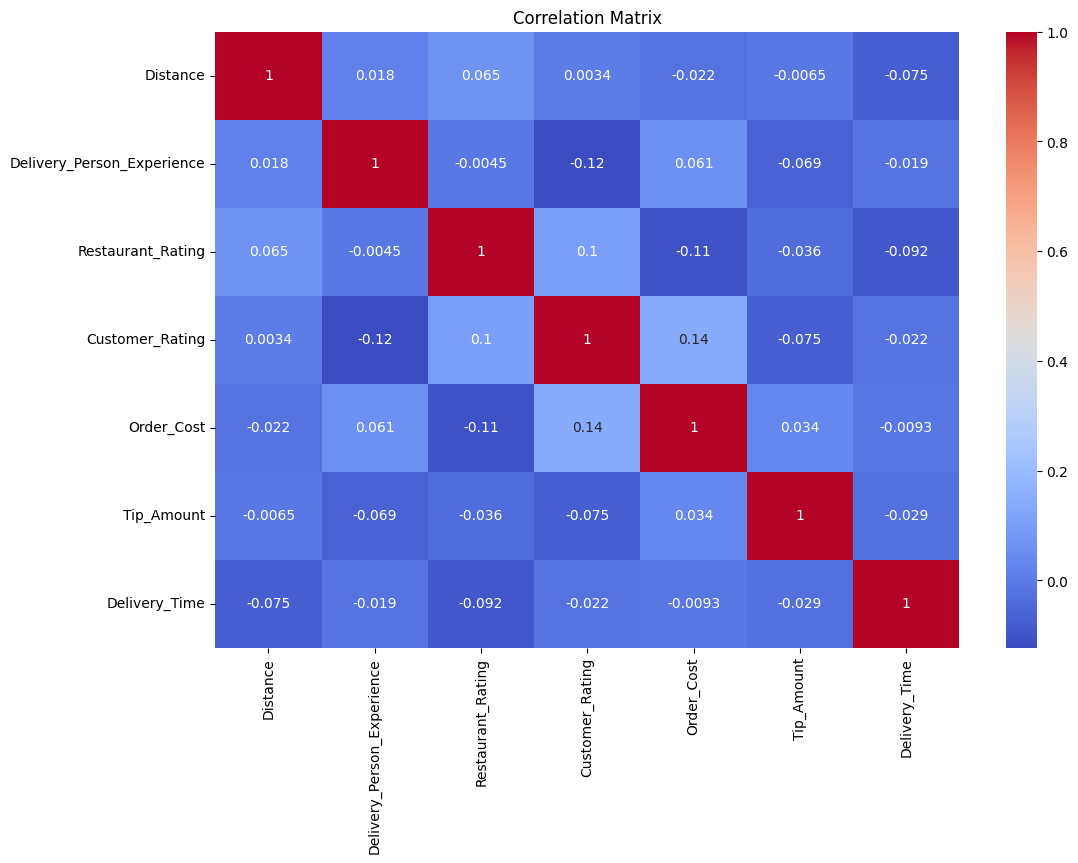

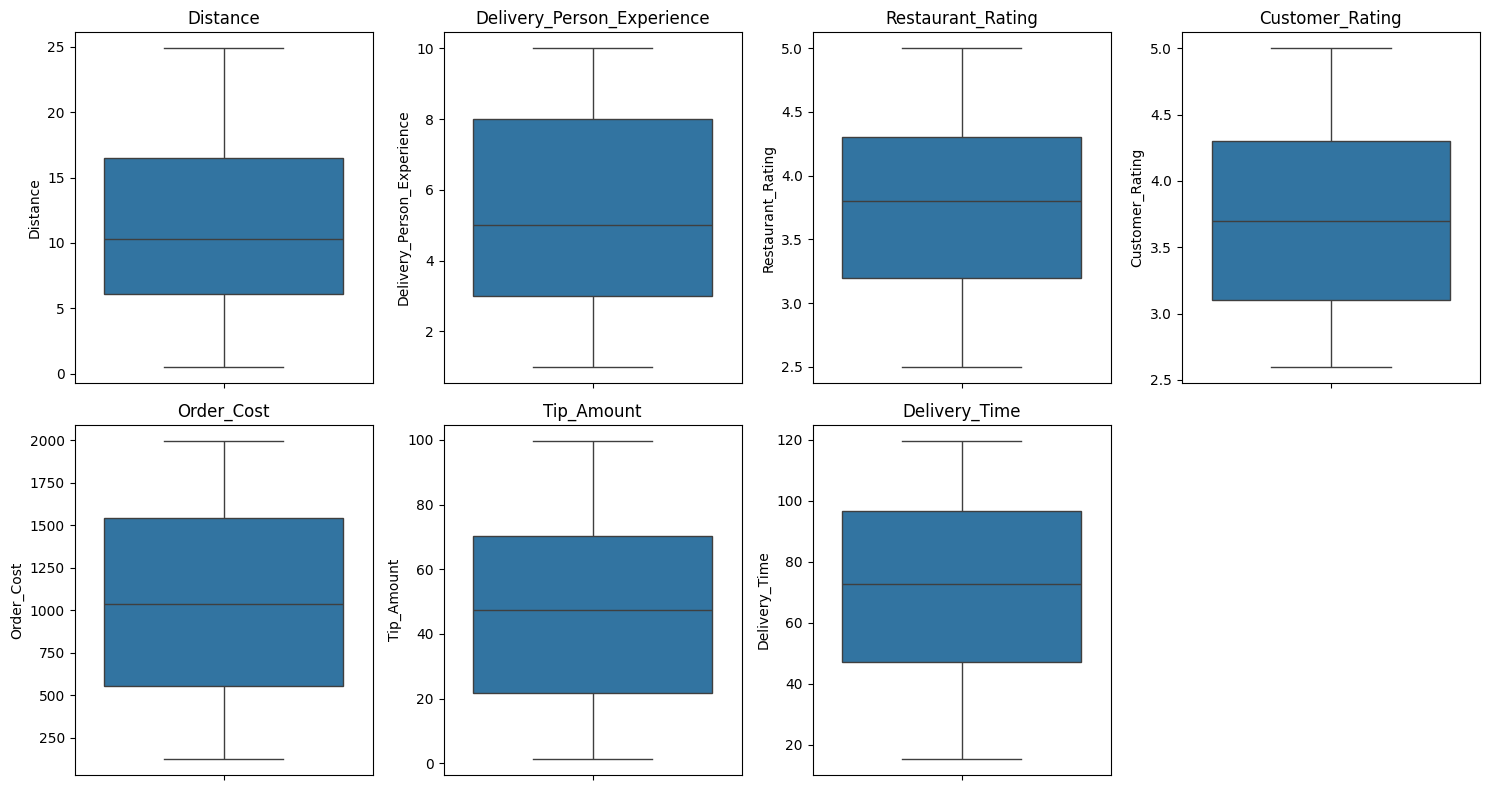

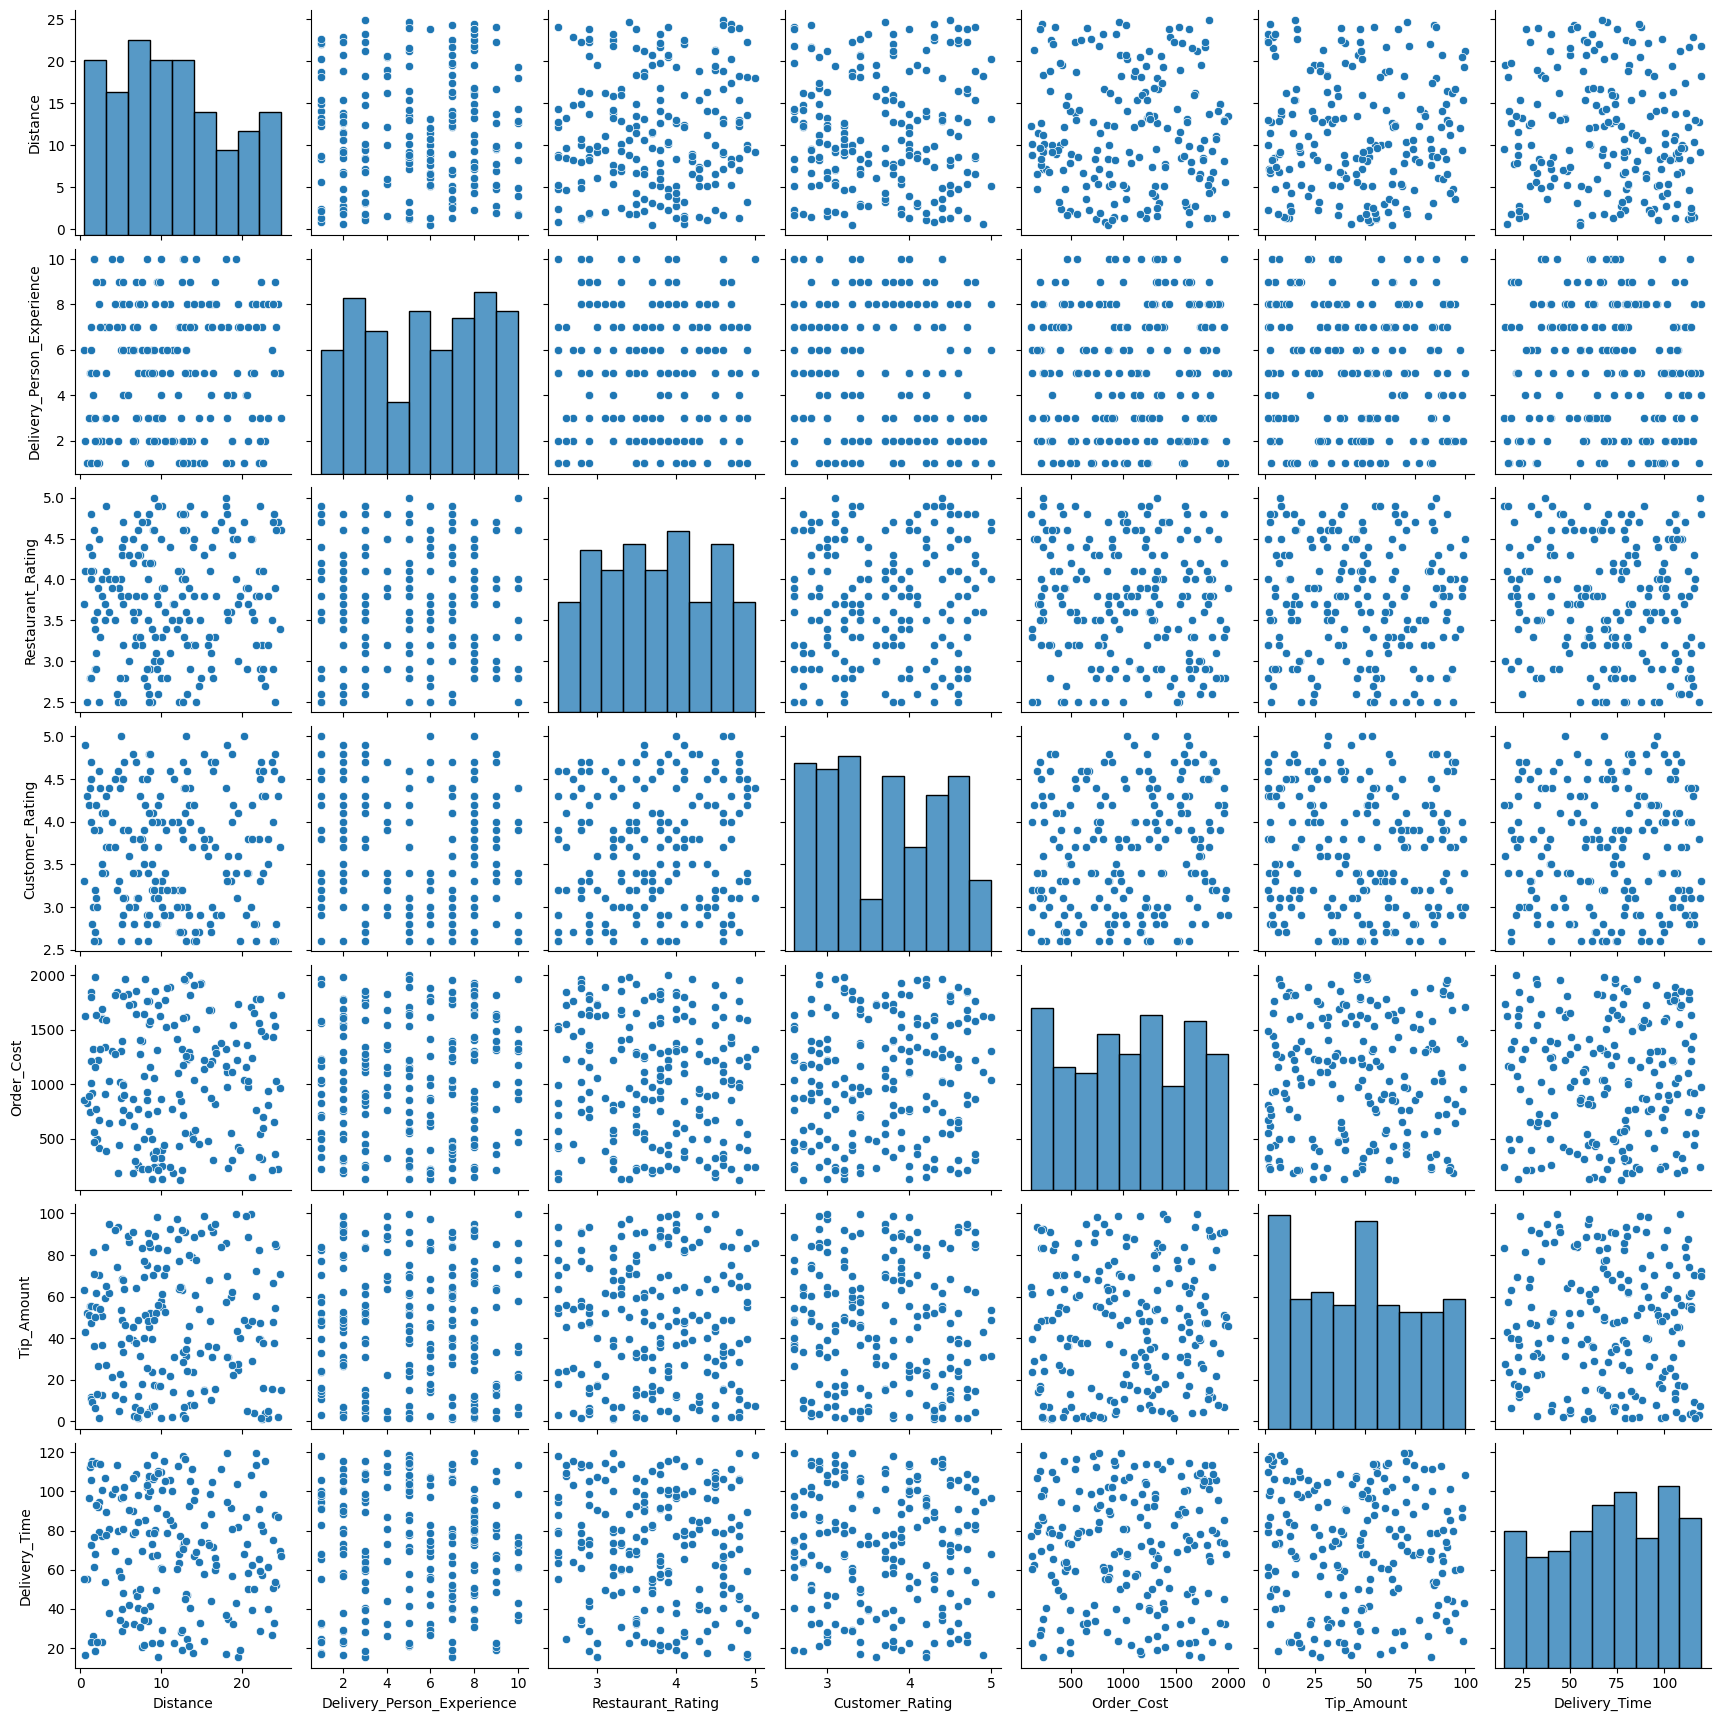

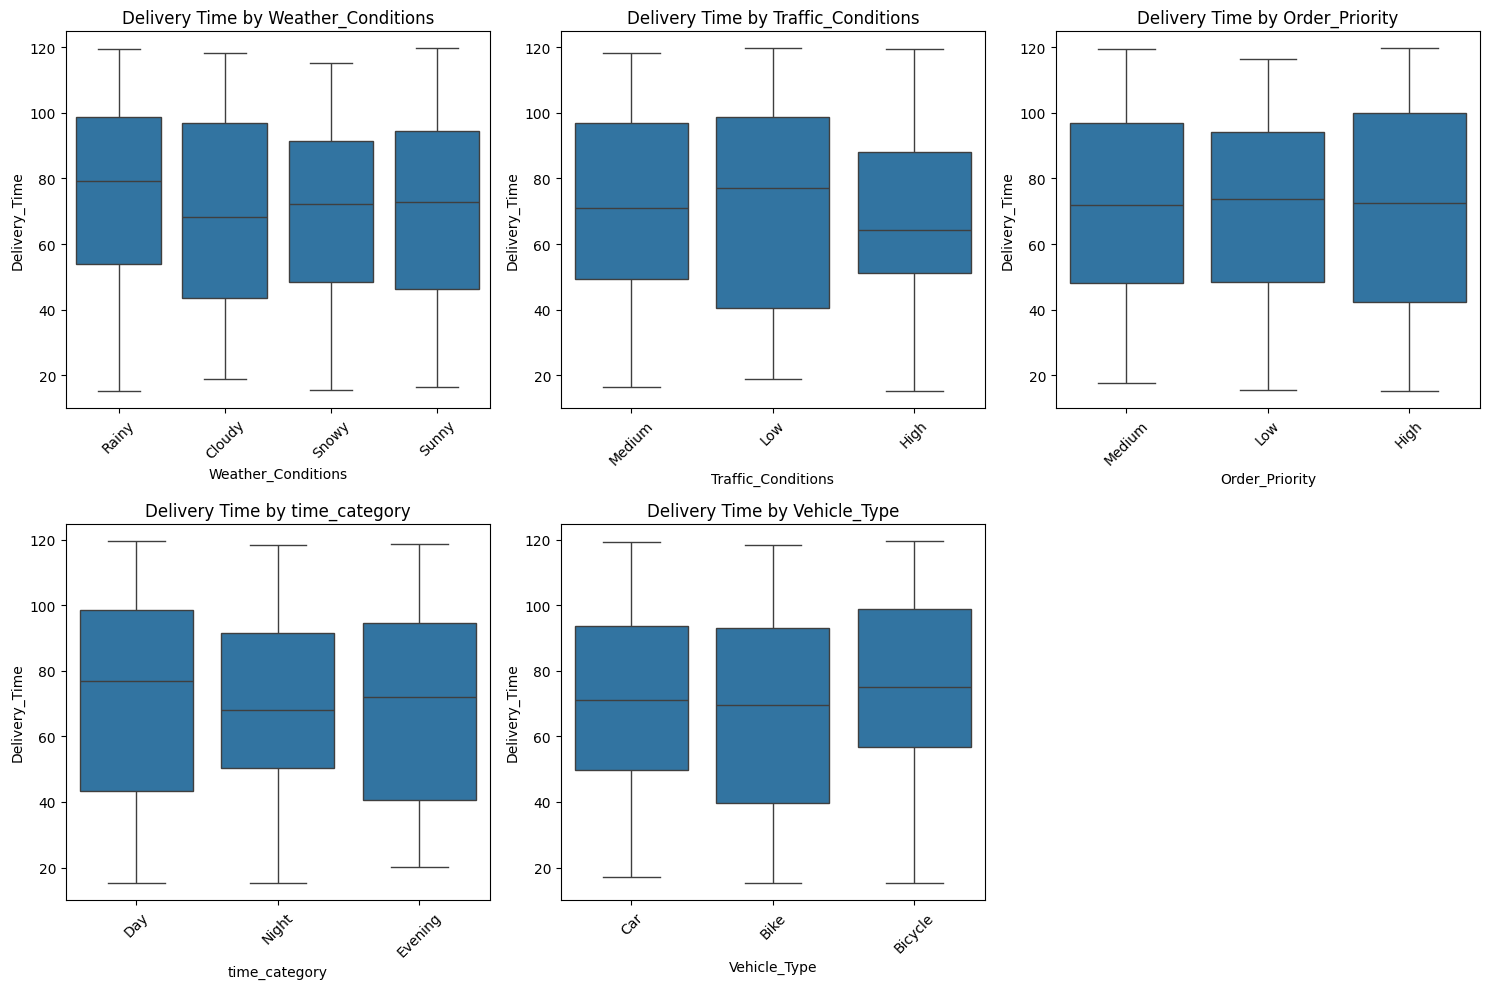

In [8]:
# Descriptive statistics
print(df.describe())

# Correlation analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols + ['Delivery_Time']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Outlier detection
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols + ['Delivery_Time'], 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Handle outliers (example for Delivery_Time)
q1 = df['Delivery_Time'].quantile(0.25)
q3 = df['Delivery_Time'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df['Delivery_Time'] >= lower_bound) & (df['Delivery_Time'] <= upper_bound)]

# Visualize relationships
sns.pairplot(df[numerical_cols + ['Delivery_Time']])
plt.show()

# Categorical variable analysis
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], y=df['Delivery_Time'])
    plt.xticks(rotation=45)
    plt.title(f'Delivery Time by {col}')
plt.tight_layout()
plt.show()

Linear Regression Performance:
Mean Squared Error: 1019.11
Root Mean Squared Error: 31.92
R-squared: -0.10
Mean Absolute Error: 27.16


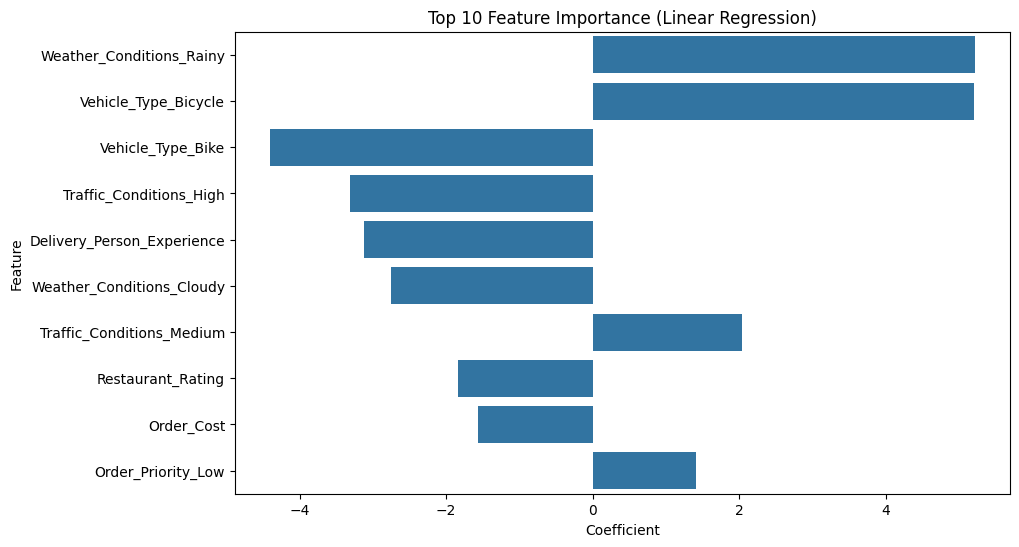

In [9]:
# Prepare data for modeling
X = df[categorical_cols + numerical_cols]
y = df['Delivery_Time']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline with preprocessing and model
linear_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train model
linear_reg.fit(X_train, y_train)

# Predictions
y_pred = linear_reg.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Linear Regression Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Feature importance (for numerical features)
try:
    coefficients = linear_reg.named_steps['regressor'].coef_
    feature_names = (numerical_cols + 
                    list(linear_reg.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)))
    
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Feature Importance (Linear Regression)')
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")

Logistic Regression Performance:
Accuracy: 0.42
Confusion Matrix:
[[10 11]
 [12  7]]
Classification Report:
              precision    recall  f1-score   support

     Delayed       0.45      0.48      0.47        21
        Fast       0.39      0.37      0.38        19

    accuracy                           0.42        40
   macro avg       0.42      0.42      0.42        40
weighted avg       0.42      0.42      0.42        40



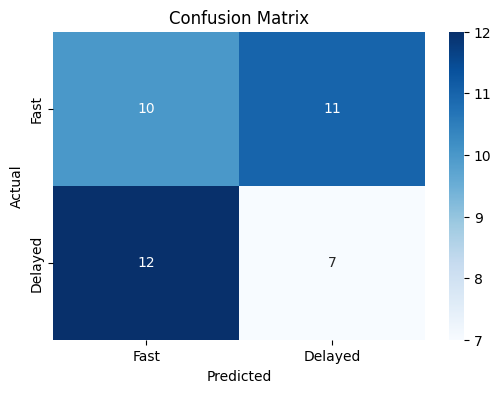

In [10]:
# Create a binary target variable (Fast/Delayed)
median_delivery_time = df['Delivery_Time'].median()
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 'Fast' if x <= median_delivery_time else 'Delayed')

# Prepare data for classification
X_class = df[categorical_cols + numerical_cols]
y_class = df['Delivery_Status']

# Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42)

# Create pipeline for classification
logistic_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train model
logistic_reg.fit(X_train_class, y_train_class)

# Predictions
y_pred_class = logistic_reg.predict(X_test_class)

# Evaluation
accuracy = accuracy_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
class_report = classification_report(y_test_class, y_pred_class)

print(f"Logistic Regression Performance:")
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fast', 'Delayed'], yticklabels=['Fast', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Model Comparison:
Linear Regression R-squared: -0.10
Logistic Regression Accuracy: 0.42


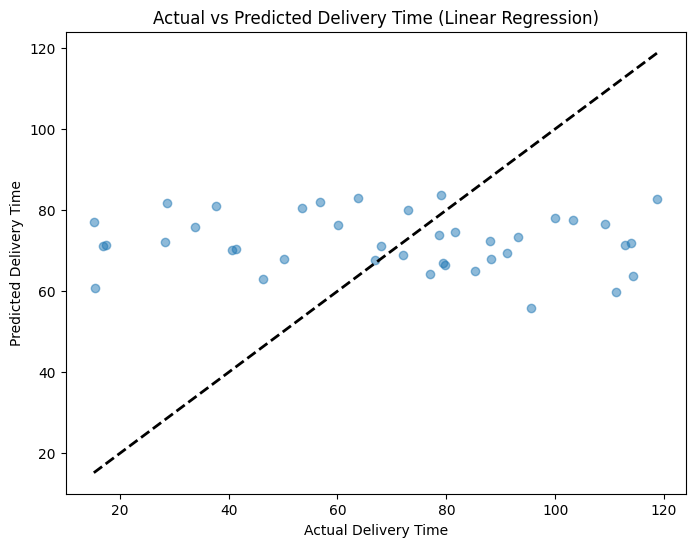

In [11]:
# Compare model performance
print("\nModel Comparison:")
print(f"Linear Regression R-squared: {r2:.2f}")
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

# Visualize actual vs predicted for regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.title('Actual vs Predicted Delivery Time (Linear Regression)')
plt.show()

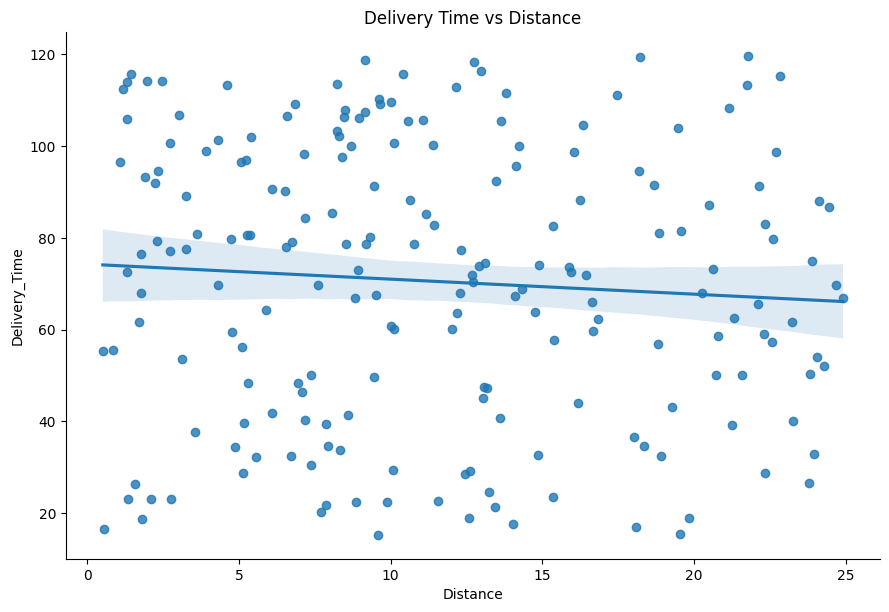

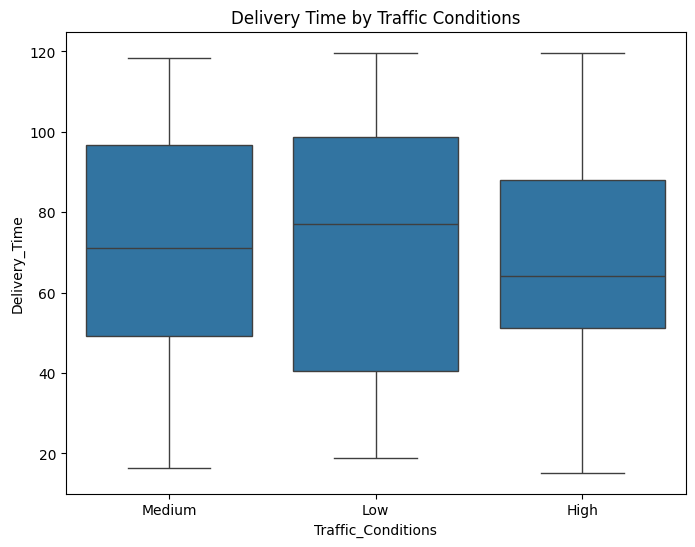

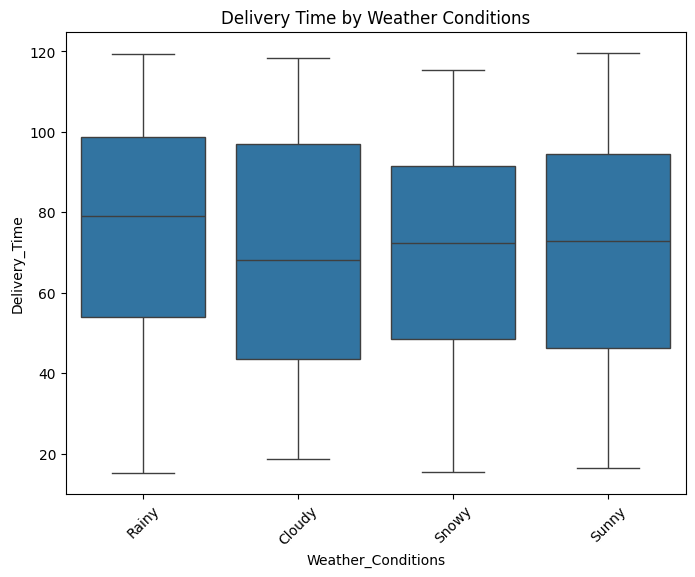

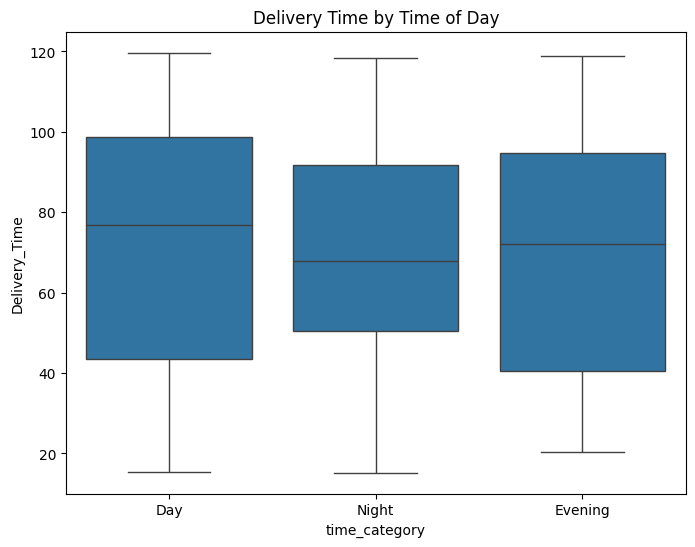

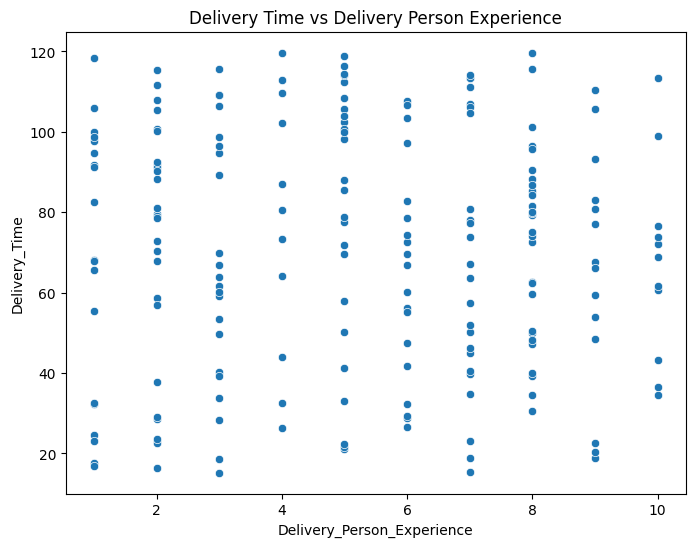


Actionable Insights and Recommendations:
1. Optimize delivery routes for longer distances to reduce delivery time.
2. Increase staffing during high-traffic periods to maintain delivery efficiency.
3. Provide additional training for less experienced delivery personnel.
4. Consider weather conditions when planning deliveries and allocate more time for adverse weather.
5. Evening deliveries tend to take longer - consider adjusting schedules or resources.


In [12]:
# Analyze factors affecting delivery time
# 1. Distance impact
sns.lmplot(x='Distance', y='Delivery_Time', data=df, height=6, aspect=1.5)
plt.title('Delivery Time vs Distance')
plt.show()

# 2. Traffic conditions impact
plt.figure(figsize=(8, 6))
sns.boxplot(x='Traffic_Conditions', y='Delivery_Time', data=df)
plt.title('Delivery Time by Traffic Conditions')
plt.show()

# 3. Weather conditions impact
plt.figure(figsize=(8, 6))
sns.boxplot(x='Weather_Conditions', y='Delivery_Time', data=df)
plt.title('Delivery Time by Weather Conditions')
plt.xticks(rotation=45)
plt.show()

# 4. Time of day impact
plt.figure(figsize=(8, 6))
sns.boxplot(x='time_category', y='Delivery_Time', data=df)
plt.title('Delivery Time by Time of Day')
plt.show()

# 5. Delivery person experience
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Delivery_Person_Experience', y='Delivery_Time', data=df)
plt.title('Delivery Time vs Delivery Person Experience')
plt.show()

# Recommendations
print("\nActionable Insights and Recommendations:")
print("1. Optimize delivery routes for longer distances to reduce delivery time.")
print("2. Increase staffing during high-traffic periods to maintain delivery efficiency.")
print("3. Provide additional training for less experienced delivery personnel.")
print("4. Consider weather conditions when planning deliveries and allocate more time for adverse weather.")
print("5. Evening deliveries tend to take longer - consider adjusting schedules or resources.")